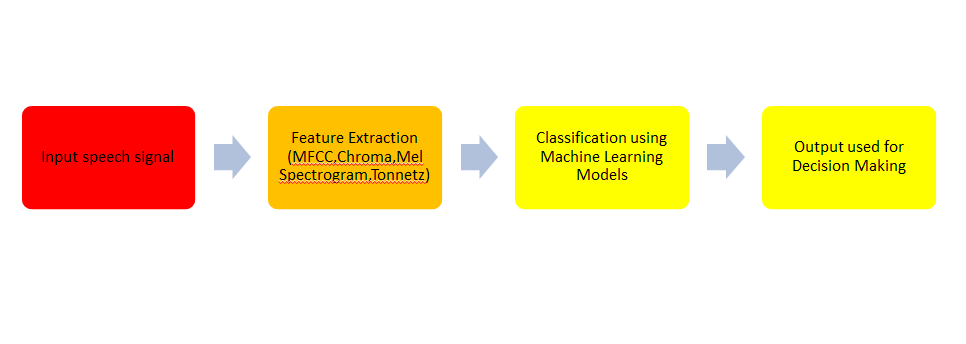

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import librosa

Sample audio data

In [ ]:
#few audio samples
  
data = ['/content/03-01-05-02-01-01-22.wav']
df = pd.DataFrame(data, columns=['Path'])
  
# print dataframe.
df

,Path
0,/content/03-01-05-02-01-01-22.wav


Feature Extraction

In [ ]:
def mfcc_feature(data,sampling_rate):
    return np.mean(librosa.feature.mfcc(y=data,n_mfcc=40,sr=sampling_rate).T,axis=0)

def mel_spectrogram_feature(data,sampling_rate):
    return np.mean(librosa.feature.melspectrogram(y=data, sr=sampling_rate).T, axis=0)

def chroma(stft,sampling_rate):
    return np.mean(librosa.feature.chroma_stft(S=stft, sr=sampling_rate).T,axis=0)
    
def tonnetz(data,sampling_rate):
    return np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(data),sr=sampling_rate).T,axis=0)



In [ ]:
#feature extraction
#function to extract the required features from the data

def feature_extraction(data,sampling_rate):

  features = np.array([])
  stft = np.abs(librosa.stft(data))
  
  #MFCC
  mfcc = mfcc_feature(data,sampling_rate)
  features = np.hstack((features, mfcc))


  # MelSpectogram
  mel = mel_spectrogram_feature(data,sampling_rate)
  features = np.hstack((features, mel)) # stacking horizontally


  #Chroma
  chrom = chroma(stft,sampling_rate)
  features = np.hstack((features,chrom))

  #tonnetz
  ton = tonnetz(data,sampling_rate)
  features = np.hstack((features,ton))


  #Spectral Contrast
  contr = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sampling_rate).T,axis=0)
  features = np.hstack((features,contr))

  return features


def get_features(audio):
    
    # duration and offset are used to take care of the no audio in start and the ending of each audio files 
    #OFFSET-START OF THE AUDIO AND DURATION-THE END TIME STAMP OF THE AUDIO
    data, sampling_rate = librosa.load(audio, duration=2, offset=0.5)
    features = feature_extraction(data,sampling_rate)
    result = np.array(features)
    
    return result

In [ ]:
X = []
for path in df.Path:
    feature = get_features(path)
    X.append(feature)
print("Extraction done")
features_extracted = pd.DataFrame(X)

Extraction done


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=1024 is too small for input signal of length=690
  n_fft, y.shape[-1]


In [ ]:
features_extracted.head(5)

,0,1,2,3,4,5,6,7,8,9,...,183,184,185,186,187,188,189,190,191,192
0,-385.130402,42.614529,-25.439041,13.448085,-6.410502,-20.333401,-18.297796,-12.644742,-22.447603,-1.605938,...,-0.020298,0.002002,-0.020651,18.134804,18.434373,20.645404,19.092533,19.846442,19.14756,46.652581


In [ ]:
features_extracted = np.expand_dims(features_extracted, axis=2)
features_extracted.shape

(1, 193, 1)

Prediction and Use Case

In [ ]:
#prediction and analysis
reconstructed_model = keras.models.load_model("/content/drive/MyDrive/SER")

In [ ]:
def decode(value):
  return 'angry' if value==0 else ('happy' if value == 1 else 'neutra' if value == 2  else 'sad')

In [ ]:
#function to display top two emotions
def use_case_evaluation(prediction):
  ind  = (-prediction).argsort()[:2]
  pred = ind[:,:2]
  decoded_string = [decode(val) for val in pred[0] ]
  prob_list = [prediction[0][val] for val in pred[0]]
  

  dict_pred = dict(zip(decoded_string, prob_list))
  return dict_pred , decoded_string
# angry = 0,happy=1 ,neutral=2,,sad = 3

In [ ]:
predictions = reconstructed_model.predict(features_extracted)

In [ ]:
print(predictions)

[[9.9993002e-01 7.0004760e-05 7.0116977e-17 4.0119015e-12]]


In [ ]:
top2_preds , decoded_string = use_case_evaluation(predictions)
print(top2_preds)

{'angry': 0.99993, 'happy': 7.000476e-05}


In [ ]:
print(decoded_string)

['angry', 'happy']


Use Case For Angry

In [ ]:
#Helper Functions

def fft_new(signal,sampFreq):
    fft_spectrum = np.fft.rfft(signal)
    freq = np.fft.rfftfreq(signal.size, d=1./sampFreq)
    fft_spectrum_abs = np.abs(fft_spectrum)
    plt.plot(freq[750:4000], fft_spectrum_abs[750:4000])
    plt.xlabel("frequency, Hz")
    plt.ylabel("Amplitude, units")
    plt.show()
    return freq[750:4000], fft_spectrum_abs[750:4000]

threshold = 283.77

def risk_assesment(val):
    max_amp = np.max(val)
    if max_amp > threshold:
      print('Alert! Reduce the speed customer at high risk')
    else:
      pass #customer not at risk
    print(max_amp)
    


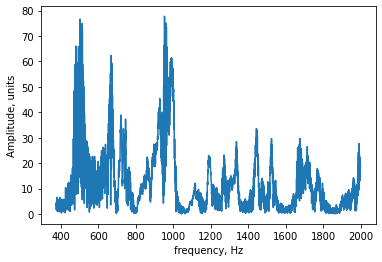

77.77292219286534


In [ ]:
audio = '/content/03-01-05-02-01-01-22.wav'
if 'angry' in decoded_string:
  data, sampling_rate = librosa.load(audio, duration=2, offset=0.5)
  freq,fft_spectrum_abs = fft_new(data,sampling_rate)
  risk_assesment(fft_spectrum_abs)
  
